### Importing libraries for EDA and formatting 

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# sns.set_style("white")
# Setting to plots with a black background
plt.style.use("dark_background")

In [25]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect(r'data/fishing.db')

cur = con.cursor()

df = pd.read_sql_query('SELECT * FROM fishing', con)


# Check if there are duplicates in the dataset (I have commented out so that it doesn't interrupt the flow when running all)
# assert df.duplicated().shape[0] == 0, "There are duplicated rows in the dataset"

# Dropping duplicated rows in the dataset
df = df.drop_duplicates()
print(df.shape)
df.head()

(11815, 21)


,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
0,2009-03-08,Changi,0.0,7.0,11.2,E,35.0,E,ESE,15.0,19.0,60.0,54.0,MED,Med,4.0,5.0,No,No,blue,33.4
1,2014-11-12,Woodlands,0.0,8.4,9.6,WNW,37.0,NNE,NW,13.0,28.0,60.0,56.0,MeD,LOw,1.0,2.0,None,Yes,blue,35.4
2,2008-08-08,Woodlands,0.0,7.6,11.1,ESE,52.0,SE,E,19.0,19.0,NaN,13.0,Med,MEd,0.0,0.0,None,No,blue,32.8
3,2015-10-12,Changi,0.0,7.2,11.4,NE,31.0,NNW,NE,9.0,13.0,51.0,53.0,hIgh,med,1.0,1.0,No,No,red,31.4
4,2013-10-27,Woodlands,5.6,7.0,8.5,NNW,33.0,N,N,13.0,19.0,68.0,64.0,meD,MeD,6.0,5.0,None,No,grey,35.4


In [83]:
# Looking at rough spread of default numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rainfall,11815.0,3.086669,11.173648,0.0,0.0,0.0,0.8,367.6
Evaporation,11741.0,5.557457,2.901247,0.0,3.4,5.4,7.4,44.0
Sunshine,11758.0,6.477904,6.037594,-13.5,3.9,8.7,10.7,13.9
WindGustSpeed,11743.0,36.664311,12.631501,9.0,28.0,35.0,43.0,126.0
WindSpeed9am,11811.0,12.467361,8.325970,0.0,7.0,11.0,17.0,65.0
WindSpeed3pm,11810.0,16.700931,7.870736,0.0,11.0,15.0,20.0,76.0
Humidity9am,11801.0,65.489196,15.451693,11.0,56.0,66.0,76.0,100.0
Humidity3pm,11790.0,50.851145,16.889701,5.0,40.0,51.0,61.0,100.0
Cloud9am,11538.0,4.122032,2.729144,0.0,1.0,4.0,7.0,8.0
Cloud3pm,11473.0,4.129434,2.648135,0.0,1.0,4.0,7.0,8.0


Notes:
- From this preliminary description, we can see that the target variable `Rainfall` has quite a large spread with at least 50% of the data collected having no rainfall at all.

Insights:
- Given that it is considered to have rained if there's more than 1.0mm of rain a day, we might have to see if the distribution of rain <= 1.0mm of rain and >1.0mm is very unbalanced or not. If it is, we might have to use techniques to balance it a little, or it would make no sense to do modelling as predicting the majority (ie. no rain) could possibly have better results than a model.

In [34]:
drop_subset = list(df.columns)
drop_subset.remove('RainToday')
a = df.dropna(axis = 0, how = 'any', subset=drop_subset)
a.shape

(10938, 21)

In [36]:
# Checking for the percentage of empty values
df.isna().sum()/len(df)*100

Date              0.000000
Location          0.000000
Rainfall          0.000000
Evaporation       0.626322
Sunshine          0.482438
WindGustDir       0.634786
WindGustSpeed     0.609395
WindDir9am        2.242912
WindDir3pm        0.397799
WindSpeed9am      0.033855
WindSpeed3pm      0.042319
Humidity9am       0.118493
Humidity3pm       0.211595
Pressure9am       0.016928
Pressure3pm       0.059247
Cloud9am          2.344477
Cloud3pm          2.894625
RainToday        24.570461
RainTomorrow      0.000000
ColourOfBoats     0.000000
AverageTemp       0.067711
dtype: float64

Notes:
- Apart from `RainToday`, other variables have less than 3% of missing data.

Insights:
- Keeping this in mind, we can either impute the missing data for the columns excluding `RainToday` or drop rows with missing data. Let us first look at the distribution of the continuous variables.

### Distribution of continuous data

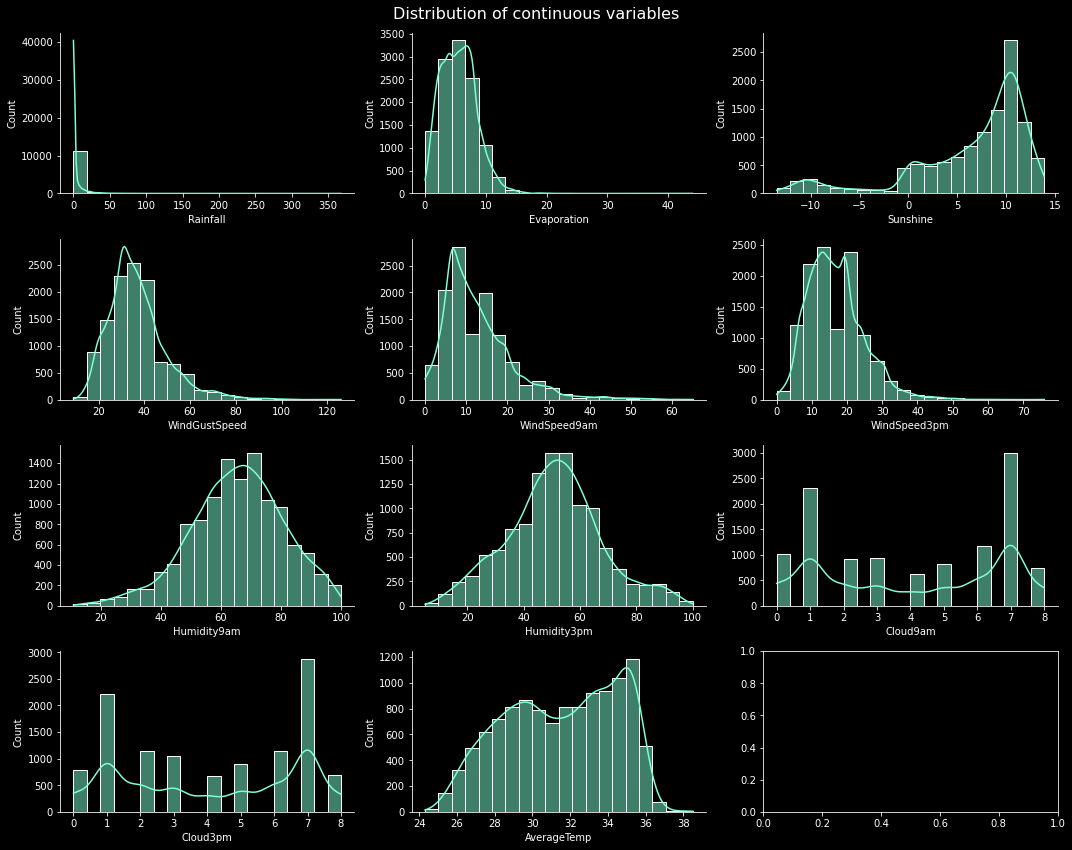

In [74]:
continuous_columns = df.select_dtypes('number').columns

fig, ax = plt.subplots(nrows=len(continuous_columns)//3+1, ncols=3, figsize = (15,12))

for i, col in enumerate(continuous_columns):
    ax_curr = ax.flatten()[i]
    sns.histplot(x=col, data = df, ax = ax_curr, color='#7FFFD4', 
                 bins = 20, kde=True)
    
    # ax_curr.spines['right', 'top'].set_visible(False)
    ax_curr.spines['top'].set_visible(False)
    ax_curr.spines['right'].set_visible(False)   

fig.suptitle('Distribution of continuous variables', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95);

Notes:
- Humidity for both 9am and 3pm have a mostly normal distributed
- Most of the other continuous variables are skewed
- For cloud coverage, most of the values are either 1 or 7, regardless of 9am or 3pm, which are 'Few clouds' and 'Broken clouds' respectively.

Insights:
- For the variables with skewed distributions, there might be a need to do a logarithmic transformation before scaling these continuous variables.

### Distribution of categorical variables

In [76]:
for col in df.select_dtypes('object').columns:
    print(f"{col}: \n", df[col].value_counts(dropna = False))

2009-03-08    4
2014-08-26    4
2014-10-11    4
2014-08-27    4
2010-08-26    4
2012-06-04    4
2009-08-13    4
2010-10-21    4
2017-04-06    4
2008-10-07    4
2016-12-26    4
2014-06-03    4
2014-11-19    4
2014-10-10    4
2011-09-07    4
2012-07-20    4
2013-10-08    4
2013-01-01    4
2017-05-04    4
2012-02-02    4
2014-10-12    4
2010-05-30    4
2012-08-22    4
2009-12-31    4
2017-05-30    4
2013-06-18    4
2009-06-20    4
2009-10-08    4
2010-04-03    4
2014-01-15    4
2014-08-19    4
2012-02-16    4
2010-09-15    4
2012-07-21    4
2012-11-30    4
2009-01-19    4
2008-10-29    4
2014-11-30    4
2009-05-09    4
2010-11-27    4
2009-09-08    4
2011-11-17    4
2013-03-20    4
2017-06-06    4
2012-10-09    4
2009-02-24    4
2016-12-15    4
2009-06-15    4
2016-11-18    4
2016-07-10    4
2012-01-18    4
2011-12-08    4
2010-06-08    4
2013-08-14    4
2009-10-27    4
2011-08-09    4
2009-06-26    4
2011-05-01    4
2014-12-30    4
2013-07-09    4
2008-10-26    4
2008-07-11    4
2014-06-

# Note, can verify if there's any rain the day after by arranging in chronological order and verifying based on the rainTomorrow

### Correlation between missing data

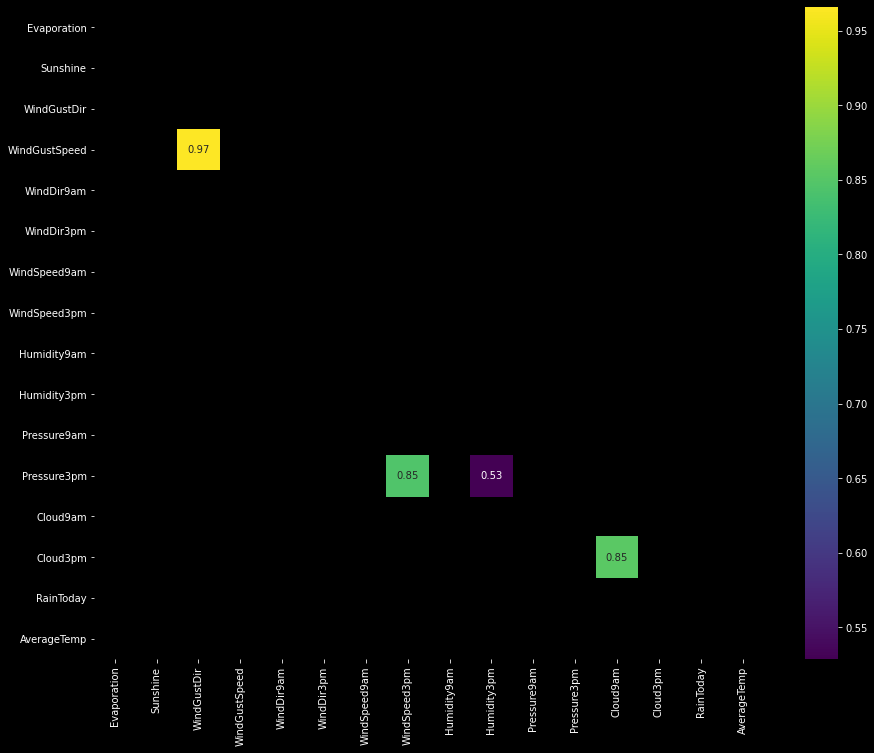

In [ ]:
# na_corr = (df.isna().corr()
#            .dropna(axis = 1, how = 'all') # dropping columns that have no correlation 
#            .dropna(axis = 0, how = 'all')) # dropping rows that have no correlation 
# mask = np.triu(np.ones_like(na_corr, dtype=bool))

# plt.figure(figsize = (15, 12))
# sns.heatmap(na_corr, annot = True, mask = mask | (np.abs(na_corr) <= 0.5), cmap = 'viridis');

Notes:
- When `WindGustDir` is missing, `WindGustSpeed` is mostly missing as well (and vice versa), given the high correlation of 0.97
- When `Pressure3pm` is missing, `WindSpeed3pm` and `Humidity3pm` are likely to be missing as well (and vice versa), given a correlation of 0.85 and 0.53 respectively.
- When `Cloud9am` is missing, `Cloud3pm` is mostly missing as well (and vice versa), given a correlation of 0.85.

Insights:
- It is possible that wind direction is missing, wind speed is missing as well. Perhaps the wind measurement was not taken or it was lost.
- It is also possible that measurements for a specific timing are taken together, which was why the 3pm measurements that were missing were correlated.
- Cloud measurements in the morning and afternoon could have also been lost or not taken together.